# L.A. Trash Collection

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

In [34]:
# https://data.lacity.org/A-Livable-and-Sustainable-City/LASAN-Solid-Resources-Tonnages-Bulky-Item-E-Waste-/qwh3-ax8z
src = pd.read_csv('/Users/mhustiles/data/data/LA/\
LASAN___Solid_Resources_Tonnages_-_Bulky_Item__E-Waste__and_White_Goods.csv')

In [35]:
trash = src

In [36]:
trash.columns = trash.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [133]:
# trash['datetime'] = pd.to_datetime(trash['datetime'], format='%m/%d/%Y')
trash['datetime'] = pd.to_datetime(trash["datetime"].dt.strftime('%Y-%m-%d'))
trash['year'] = trash['datetime'].dt.year
trash['quarter'] = trash['datetime'].dt.quarter
trash['day'] = trash['datetime'].dt.day
trash['month'] = trash['datetime'].dt.month
trash['weekday'] = trash['datetime'].dt.weekday_name
trash['monthname'] = trash['datetime'].dt.month_name()

In [134]:
trash = trash[trash['datetime'] > '01/01/2016']
trash18 = trash[(trash['datetime'] > '01/01/2017') & (trash['datetime'] < '01/01/2019')]

In [135]:
trash.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname
0,CSLA Harbor,FB90,2019-06-17,Allied Waste Transfer - Wilmington,1140285,1.50,B,Bulky,2019,2,17,6,Monday,June
1,CSLA Harbor,FB90,2019-06-17,Allied Waste Transfer - Wilmington,1140285,0.10,B,Bulky,2019,2,17,6,Monday,June
2,CSLA Harbor,FB90,2019-06-17,Allied Waste Transfer - Wilmington,1140285,3.80,B,Bulky,2019,2,17,6,Monday,June
3,CSLA Harbor,FB91,2019-06-17,Allied Waste Transfer - Wilmington,1140206,0.27,B,Bulky,2019,2,17,6,Monday,June
4,CSLA Harbor,FB91,2019-06-17,Allied Waste Transfer - Wilmington,1140206,0.27,B,Bulky,2019,2,17,6,Monday,June


In [136]:
route_commodity_years = trash.groupby(['year', 'route', 'generalcommodity'])\
    .agg({'tons': np.sum}).reset_index().sort_values(by='tons', ascending=False)

In [137]:
route_commodity_months = trash.groupby(['year', 'month', 'route', 'generalcommodity'])\
    .agg({'tons': np.sum}).reset_index().sort_values(by='tons', ascending=False)

In [138]:
district_commodity = trash.groupby([ 'district', 'generalcommodity'])\
    .agg({'tons': np.sum}).reset_index().sort_values(by='tons', ascending=False)

In [139]:
daily_2018 = trash18.groupby([ 'datetime'])\
    .agg({'tons': np.sum}).reset_index().sort_values(by='tons', ascending=False)

In [149]:
daily_trash = daily[daily.generalcommodity == 'Refuse'].groupby(['generalcommodity', 'datetime'])\
    .agg({'tons': np.sum}).reset_index().sort_values(by='datetime', ascending=True)

In [150]:
daily_trash['tons'] = daily_trash['tons'].round()

In [151]:
daily_trash.to_csv('/Users/mhustiles/data/github/notebooks/la-sanitation/output/daily_trash.csv')

In [152]:
daily_trash.head()

,generalcommodity,datetime,tons
0,Refuse,2016-01-02,3372.0
1,Refuse,2016-01-03,36.0
2,Refuse,2016-01-04,3366.0
3,Refuse,2016-01-05,3543.0
4,Refuse,2016-01-06,3461.0


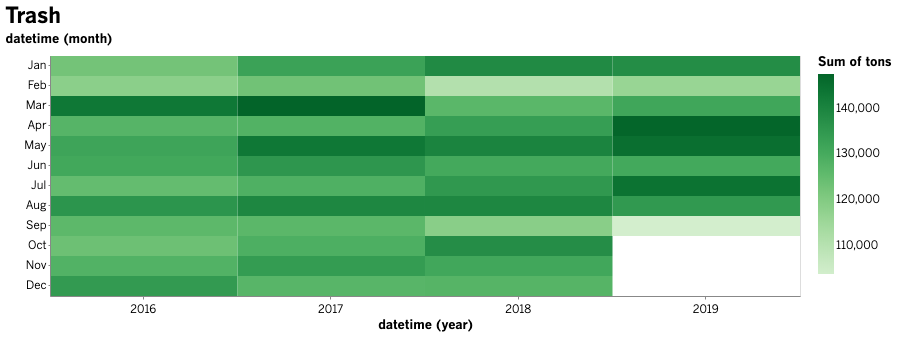

In [153]:
alt.Chart(
    daily,
    title="Trash"
).mark_rect().encode(
    x='year(datetime):O',
    y='month(datetime):O',
    color=alt.Color('sum(tons):Q', scale=alt.Scale(scheme="greens")),
    tooltip=[
        alt.Tooltip('month(datetime):T', title='Date'),
        alt.Tooltip('sum(tons):Q', title='Tons')
    ]
).properties(width=750)